# GSE59114 - Kowalczyk
## Xiaonan Wang
## 24May2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns
import smqpp

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print(smqpp.__version__)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5
0.1.2


# Read in and tidyup

In [2]:
GSE59114 = sc.read("./Data/GSE59114_m1.txt").T

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [3]:
meta = pd.read_csv("./Data/GSE59114_meta.txt", sep='\t')
print(meta.shape)

(1428, 3)


In [4]:
GSE59114.obs = meta

# QC and normalisation

In [5]:
sc.pp.filter_genes(GSE59114, min_cells=1)

In [6]:
GSE59114.shape

(1428, 8422)

In [7]:
GSE59114.write('./write/raw_GSE59114.h5ad')

/home/xw251/miniconda3/envs/scanpy182/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age' as categorical
/home/xw251/miniconda3/envs/scanpy182/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ct' as categorical
/home/xw251/miniconda3/envs/scanpy182/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in

In [8]:
GSE59114.X = 2**(GSE59114.X)-1

In [9]:
# normalisation
sc.pp.normalize_per_cell(GSE59114, counts_per_cell_after=1e4)
sc.pp.log1p(GSE59114)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [10]:
GSE59114.raw = GSE59114

In [11]:
GSE59114.obs.head()

,age,ct,batch,n_counts
young_LT_HSC_2,young,LTHSC,b1,971509.8125
young_LT_HSC_6,young,LTHSC,b1,972504.3750
young_LT_HSC_8,young,LTHSC,b1,967960.0625
young_LT_HSC_9,young,LTHSC,b1,975070.2500
young_LT_HSC_10,young,LTHSC,b1,980532.3750


In [12]:
GSE59114.write('./write/norm_GSE59114.h5ad')

# p53 Score Calculation

In [13]:
GSE59114 = sc.read('./write/norm_GSE59114.h5ad')

In [14]:
GSE59114_norm = anndata.AnnData(X=GSE59114.raw.X, obs=GSE59114.obs, var=GSE59114.raw.var)

In [15]:
sc.pp.scale(GSE59114_norm)

In [16]:
p53GL = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/Analysis_17Feb2021/p53GL.txt', dtype='str')

In [17]:
print(p53GL)

['Aen' 'Bax' 'Bbc3' 'Casp1' 'Ccng1' 'Cdkn1a' 'Ctsd' 'Eda2r' 'Ier5' 'Perp'
 'Phlda3' 'Pml' 'Pvt1' 'Sulf2' 'Tnfrsf10b' 'Zmat3']


In [18]:
sc.tl.score_genes(GSE59114_norm,np.array(p53GL), score_name = 'p53S', use_raw=False)

computing score 'p53S'
    finished: added
    'p53S', score of gene set (adata.obs).
    350 total control genes are used. (0:00:00)


In [19]:
GSE59114.obs['p53S'] = GSE59114_norm.obs['p53S']

In [28]:
GSE59114.obs['age'] = GSE59114.obs['age'].astype('category')

In [29]:
GSE59114.obs['age'].cat.categories

Index(['old', 'young'], dtype='object')

In [30]:
GSE59114.obs['age'] = GSE59114.obs['age'].cat.reorder_categories(['young', 'old'])

In [31]:
GSE59114.write('./write/processed_GSE59114.h5ad')

In [26]:
GSE59114 = sc.read('./write/processed_GSE59114.h5ad')

In [32]:
# Extract HSCs only
GSE59114 = GSE59114[GSE59114.obs['ct'] != 'MPP']

In [33]:
GSE59114.obs['ct'].value_counts()

LTHSC    539
STHSC    533
Name: ct, dtype: int64

young v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.904e-03 U_stat=1.100e+05


(<AxesSubplot:title={'center':'HSC'}, ylabel='p53S'>,
 [<statannot.StatResult.StatResult at 0x2b691ff8d7c0>])

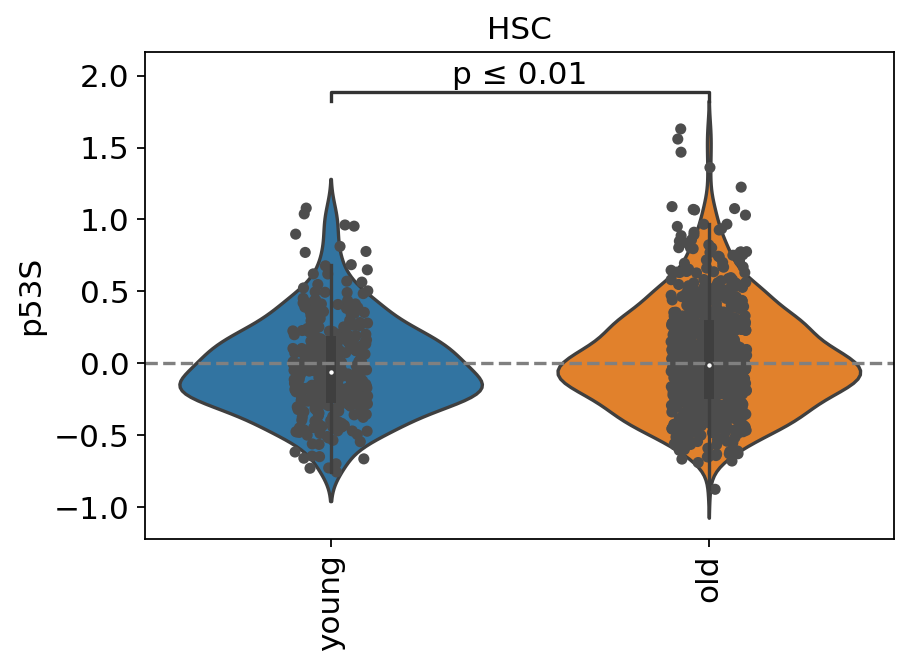

In [35]:
# Figure6C
from statannot import add_stat_annotation
fig, ax = plt.subplots(figsize=(6,4))
sns.violinplot(x='age', y='p53S', scale='width', data=GSE59114.obs, ax=ax)
sns.stripplot(x="age", y="p53S", data=GSE59114.obs, jitter=True, zorder=1, color=".3")
ax.set_xticklabels(labels=GSE59114.obs['age'].cat.categories,rotation=90)
ax.grid(False)
ax.set_xlabel('')
ax.set_title('HSC')
ax.axhline(y=0, linestyle="--", c='grey')
add_stat_annotation(ax, data=GSE59114.obs, x='age', y='p53S',
                        box_pairs=[('old', 'young')],
                        test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)